# Solving Wave PDE equation with MLP

One of the simplest examples of solving PDEs with neural networks is considered in this notebook. A problem is set up in such a way that it admits an exact solution, which can be compared to a PINN approximation. The heat transfer example is based on the **one-dimensional wave equation**
$$
\frac{\partial^2 u}{\partial t^2} - {c^2} \frac{\partial^2 u}{\partial x^2} = 0, \quad
t \in [0, T], \quad x \in [0, L].
$$
Dirichlet boundary conditions $u(t, 0) = u(t, L) = 0$ for $t \in [0, T]$ and initial conditions $u(0, x) = \sin \left( \frac{n \pi x}{L} \right)$ and $u_t(0,x) = \frac{n \pi c}{L}\sin \left( \frac{n \pi x}{L} \right)$ for $x \in [0, L]$ and a certain $n \in \{1, 2, \ldots\}$ are imposed. Through **separation of variables** one can obtain the factorized solution as
$$
u(t, x) = \sin \left( \frac{n \pi}{L} x \right) \left(\cos \left( \frac{n \pi}{L} ct \right) + \sin \left( \frac{n \pi}{L} ct \right)\right)$$
Equations with other differential operators or boundary conditions can be addressed analogously though. The goal is then to construct a NN model $u_{\boldsymbol{\theta}}(t, \boldsymbol{x})$ that approximately solves the governing equations. It will be convenient in the following to define the **residual** of the NN approximation as
$$
r_{\boldsymbol{\theta}}(t, \boldsymbol{x}) =
\frac{\partial^2 u}{\partial t^2} - {c^2} \frac{\partial^2 u}{\partial x^2}
$$
One can now construct a **physics-based loss function** $L_{\mathrm{physics}} = \lambda_r L_{\mathrm{residual}} + \lambda_i L_{\mathrm{initial}} + \lambda_b L_{\mathrm{boundary}}$ that is tailored for solving the PDE. It contains three components that penalize nonzero residuals and deviations from the initial and boundary conditions, respectively. The relative importance of those term can be adjusted with scalar weights $\lambda_r, \lambda_i, \lambda_b > 0$. The different loss terms are explicitly given as
$$
\begin{align*}
L_{\mathrm{residual}} &= \frac{1}{N_r} \sum_{j=1}^{N_r}
\left( r_{\boldsymbol{\theta}}(t_j^{(r)}, \boldsymbol{x}_j^{(r)}) \right)^2,
\quad t_j^{(r)} \in [0, T], \quad \boldsymbol{x}_j^{(r)} \in \Omega, \\
L_{\mathrm{initial}} &= \frac{1}{N_i} \sum_{j=1}^{N_i}
\left( u_0(\boldsymbol{x}_j^{(i)}) -
u_{\boldsymbol{\theta}}(0, \boldsymbol{x}_j^{(i)}) \right)^2,
\quad \boldsymbol{x}_j^{(i)} \in \Omega, \\
L_{\mathrm{boundary}} &= \frac{1}{N_b} \sum_{j=1}^{N_b}
\left( u_{\mathrm{b}}(t_j^{(b)}, \boldsymbol{x}_j^{(b)}) -
u_{\boldsymbol{\theta}}(t_j^{(b)}, \boldsymbol{x}_j^{(b)}) \right)^2,
\quad t_j^{(b)} \in [0, T], \quad \boldsymbol{x}_j^{(b)} \in \partial \Omega.
\end{align*}
$$
Here, the **collocation points** $\{(t_j^{(r)}, \boldsymbol{x}_j^{(r)})\}_{j=1}^{N_r}$ test the residual within the domain. Similarly, points at the space-time boundary $\{\boldsymbol{x}_j^{(i)}\}_{j=1}^{N_i}$ and $\{(t_j^{(b)}, \boldsymbol{x}_j^{(b)})\}_{j=1}^{N_b}$ test the boundary conditions. An approximate solution $u_{\hat{\boldsymbol{\theta}}}(t, \boldsymbol{x})$ can eventually be computed by finding the NN weights $\hat{\boldsymbol{\theta}} = \operatorname{argmin}_{\boldsymbol{\theta}} L_{\mathrm{physics}}$ that minimize the physics loss.

## PINN loss

The procedure presented so far actually makes for a generic PDE solver. In a wider context though, it may be important to incorporate some actual experimental data into the scientific modeling process. This could compensate for the inevitable uncertainties and inadequacies to some degree. PINNs offer an elegant mechanism to combine physical knowledge with real data. Given a set of data $\{(t_i, \boldsymbol{x}_i, u_{\mathrm{meas}}(t_i, \boldsymbol{x}_i))\}_{i=1}^N$ one can simply consider an additional **regression loss**
$$
L_{\mathrm{data}} =
\frac{1}{N} \sum_{i=1}^N \left( u_{\mathrm{meas}}(t_i, \boldsymbol{x}_i) -
u_{\boldsymbol{\theta}}(t_i, \boldsymbol{x}_i) \right)^2.
$$
It is remarked here that, in a surrogate modeling context, such input-output data could in principle also come from a high-fidelity simulator. A PINN can be trained by minimizing the physics and regression losses as a function of the NN weights. For the sake of completeness, the complete **PINN loss** is written as
$$
L = L_{\mathrm{data}} + \lambda_r L_{\mathrm{residual}} + \lambda_i L_{\mathrm{initial}} + \lambda_b L_{\mathrm{boundary}}.
$$

In [58]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of utils.model failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/content/utils/model.py", line 23
    return model
    ^^^^^^^^^^^^
SyntaxErro

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '' # The location in which utils file is stored
sys.path.append(path)

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import (
    Wave_1D_Equation,
    PINN,
    train_pinn,
    make_colors
)

In [60]:
_ = torch.manual_seed(752) # do not change this at all

## Problem setup

As a first step, we formulate a specific heat transfer problem by setting the defining physical parameters. An instance `simple_problem` of the class `Wave_1D_Equation` is created to that end.

In [61]:
c = 0.07 # wave speed coefficient
length = 1.0 # space length
maxtime = 1.0 # time length
n = 3 # initial condition

simple_problem = Wave_1D_Equation(
    c=c,
    length=length,
    maxtime=maxtime,
    n=n
)

## Exact solution

The problem defined above admits an analytical solution. It can be computed by calling the class instance we just created for certain time and location inputs. This simply looks like `u_values = simple_problem(t=t, x=x)` in the code.

In [62]:
t_values = torch.linspace(0, maxtime, 1001)
x_values = torch.linspace(0, length, 1001)

t = t_values.view(-1, 1) # (time, 1)
x = x_values.view(1, -1) # (1, space)

u_values = simple_problem(t=t, x=x) # (time, space)

In the cells below, the exact solution from above is visualized in two different ways.

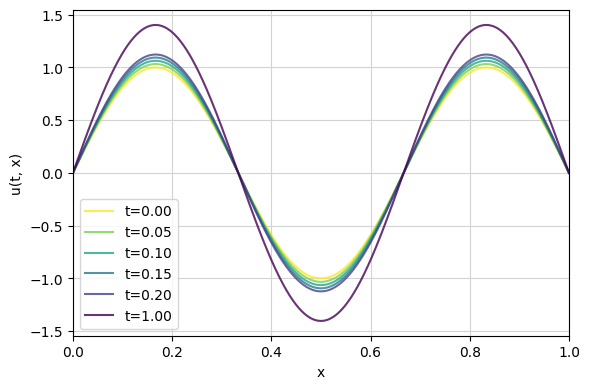

In [63]:
tids = (0, 50, 100, 150, 200, -1)
colors = make_colors(len(tids), seq_cm=plt.cm.viridis_r, ensure_seq=True)

fig, ax = plt.subplots(figsize=(6, 4))
for tidx, color in zip(tids, colors):
    ax.plot(
        x_values.numpy(), u_values[tidx,:].numpy(),
        color=color, alpha=0.8,
        label='t={:.2f}'.format(t_values[tidx].item())
    )
ax.set(xlabel='x', ylabel='u(t, x)')
ax.set_xlim((x_values.min(), x_values.max()))
ax.legend()
ax.grid(visible=True, which='both', color='lightgray', linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

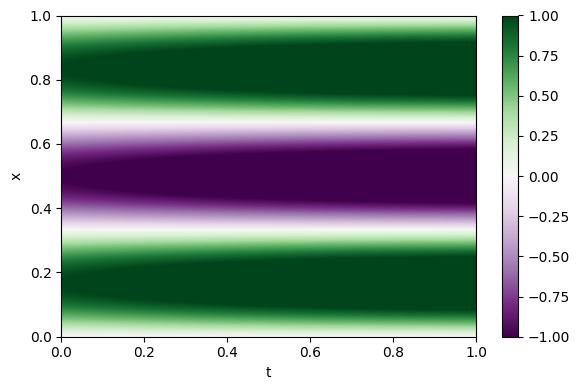

In [64]:
fig, ax = plt.subplots(figsize=(6, 4))
img = ax.imshow(
    u_values.numpy().T,
    cmap='PRGn',
    aspect='auto',
    interpolation='bilinear',
    vmin=np.round(u_values.min()),
    vmax=np.round(u_values.max()),
    origin='lower',
    extent=(0, maxtime, 0, length)
)
ax.set(xlabel='t', ylabel='x')
fig.colorbar(img, ax=ax)
fig.tight_layout()

## PINN approximation

An approximation to the exact solution is now computed. We therefore instantiate a `PINN`-object that constructs a feedforward NN as the prediction model and features dedicated methods for computing the losses. A small number of architectural parameters and loss weights have to be set.

In [69]:
num_inputs = 2 # number of inputs
num_outputs = 1 # number of outputs
num_hidden = [100, 60,60,60] # number of hidden neurons
activation = 'Tanh' # activation function

pde_weight = 1 # weight of the PDE loss
bc_weight = 1 # weight of the BC loss
ic_weight = 3 # weight of the IC loss
reduction = 'mean' # loss reduction mode

pinn = PINN(
    num_inputs,
    num_outputs,
    num_hidden=num_hidden,
    activation=activation,
    pde_weight=pde_weight,
    bc_weight=bc_weight,
    ic_weight=ic_weight,
    reduction=reduction,
    c=c,
    length=length,
    maxtime=maxtime,
    n=n
)

Two sets of collocation points are randomly sampled for training and validation purposes. They remain fixed throughout the training once they are created. It is noted that, of course, one could randomly resample during training or opt for a non-random selection as well.

In [70]:
train_nums = {
    'num_pde': 100, # number of train samples for PDE loss
    'num_bc': 100, # number of train samples for BC loss
    'num_ic': 100 # number of train samples for IC loss
}

val_nums = {
    'num_pde': 100, # number of val. samples for PDE loss
    'num_bc': 100, # number of val. samples for BC loss
    'num_ic': 100 # number of val. samples for IC loss
}

train_colloc = pinn.make_collocation(**train_nums)
val_colloc = pinn.make_collocation(**val_nums)

The function `train_pinn` implements a non-batched PINN training scheme for fixed collocation points. It runs on the CPU due to the problem being rather small-scale after all. No data-based regression loss is used here, such that the training proceeds by minimizing only a physics-based loss function.

In [71]:
num_epochs = 10000 # number of training epochs

optimizer = torch.optim.Adam(pinn.parameters(), lr=0.001)

history = train_pinn(
    pinn,
    optimizer,
    num_epochs,
    train_colloc,
    val_colloc,
    print_every=100
)

 Epoch 0,Training Loss : 5.761571884155273 , Validation Loss: 6.2071685791015625
 Epoch 100,Training Loss : 2.0175158977508545 , Validation Loss: 2.0346615314483643
 Epoch 200,Training Loss : 2.0196166038513184 , Validation Loss: 2.0363757610321045
 Epoch 300,Training Loss : 2.0290021896362305 , Validation Loss: 2.02016282081604
 Epoch 400,Training Loss : 2.058035373687744 , Validation Loss: 2.0088677406311035
 Epoch 500,Training Loss : 1.9774984121322632 , Validation Loss: 1.966369390487671
 Epoch 600,Training Loss : 1.605462670326233 , Validation Loss: 1.6040699481964111
 Epoch 700,Training Loss : 0.9582780599594116 , Validation Loss: 0.9138404726982117
 Epoch 800,Training Loss : 0.6287060976028442 , Validation Loss: 0.7131017446517944
 Epoch 900,Training Loss : 0.5731602907180786 , Validation Loss: 0.579100489616394
 Epoch 1000,Training Loss : 0.6586734056472778 , Validation Loss: 0.5764557123184204
 Epoch 1100,Training Loss : 0.49945759773254395 , Validation Loss: 0.375671923160553

Let us have a look at the learning curves.

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(history['Train loss'], alpha=0.7, label='train')
ax.plot(history['Val loss'], alpha=0.7, label='val')
ax.set(xlabel='epoch', ylabel='physics loss')
ax.set_xlim((0, max(len(history['Train loss']), len(history['Val loss'])) - 1))
ax.set_yscale('log')
ax.legend()
ax.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

In order to assess the quality of the trained PINN, one can compare its predictions to the exact solution. This requires to evaluate the approximation on a grid of input values.

In [76]:
x_grid ,t_grid= torch.meshgrid( x_values,t_values, indexing='ij')
combined_tensor = torch.stack([t_grid.reshape(-1),x_grid.reshape(-1)]).T
pinn.eval()
with torch.no_grad():
    pred_values = pinn(combined_tensor) # (time * space, 1)
    pred_values = pred_values.reshape(*t_grid.shape) # (time, space)

It is finally time to plot the obtained approximation. This is done in the same two ways as for the analytical solution.

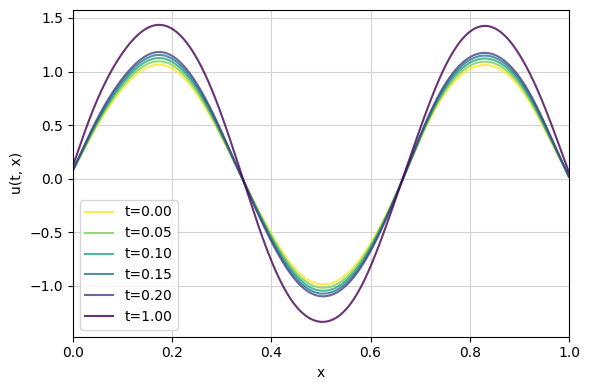

In [77]:
fig, ax = plt.subplots(figsize=(6, 4))
for tidx, color in zip(tids, colors):
    ax.plot(
        x_values.numpy(), pred_values[:,tidx].numpy(),
        color=color, alpha=0.8,
        label='t={:.2f}'.format(t_values[tidx].item())
    )
ax.set(xlabel='x', ylabel='u(t, x)')
ax.set_xlim((x_values.min(), x_values.max()))
ax.legend()
ax.grid(visible=True, which='both', color='lightgray', linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

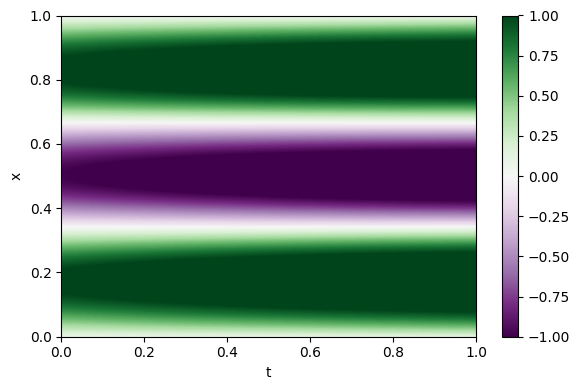

In [78]:
fig, ax = plt.subplots(figsize=(6, 4))
img = ax.imshow(
    pred_values.numpy(),
    cmap='PRGn',
    aspect='auto',
    interpolation='bilinear',
    vmin=np.round(pred_values.min()),
    vmax=np.round(pred_values.max()),
    origin='lower',
    extent=(0, maxtime, 0, length)
)
ax.set(xlabel='t', ylabel='x')
fig.colorbar(img, ax=ax)
fig.tight_layout()

Did you get the same answer as the exact one ??!!

Now, imagine that your PDE is so hard to get the exact solution. Well, PINN is there to help you.!!